Text(0, 0.5, 'Percentage of people who are left-handed')

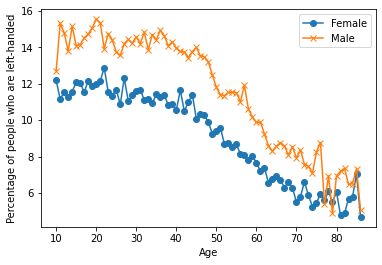

In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 


data_url_1 = "https://gist.githubusercontent.com/mbonsma/8da0990b71ba9a09f7de395574e54df1/raw/aec88b30af87fad8d45da7e774223f91dad09e88/lh_data.csv"
lefthanded_data = pd.read_csv(data_url_1)

# Plot male and female left-handedness rates vs. age
%matplotlib inline
fig, ax = plt.subplots() # create figure and axis objects
ax.plot(lefthanded_data["Age"], lefthanded_data["Female"], label='Female', marker = 'o') # plot "Female" vs. "Age"
ax.plot(lefthanded_data["Age"], lefthanded_data["Male"], label='Male', marker = 'x') # plot "Male" vs. "Age"
ax.legend() # add a legend
ax.set_xlabel("Age")
ax.set_ylabel("Percentage of people who are left-handed")

Text(0, 0.5, 'Percentage of people who are left-handed')

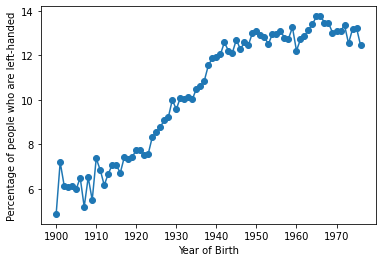

In [2]:
# Create a new column for birth year of each age
lefthanded_data['Birth_year'] = 1986 - lefthanded_data['Age']

# Create a new column for the average of male and female
lefthanded_data['Mean_lh'] = (lefthanded_data['Male'] + lefthanded_data['Female']) / 2

# Create a plot of the 'Mean_lh' column vs. 'Birth_year'
fig, ax = plt.subplots()
ax.plot(lefthanded_data['Birth_year'], lefthanded_data['Mean_lh'], marker='o')
ax.set_xlabel("Year of Birth")
ax.set_ylabel("Percentage of people who are left-handed")

In [3]:
# Import the necessary library
import numpy as np

# Define the function for P(LH | A)
def P_lh_given_A(ages_of_death, study_year = 1990):
    """ P(Left-handed | ages of death), calculated based on the reported rates of left-handedness.
    Inputs: numpy array of ages of death, study_year
    Returns: probability of left-handedness given that subjects died in `study_year` at ages `ages_of_death` """
    
    # Use the mean of the 10 last and 10 first points for left-handedness rates before and after the start 
    early_1900s_rate = lefthanded_data['Mean_lh'].tail(10).mean() 
    late_1900s_rate = lefthanded_data['Mean_lh'].head(10).mean()
    middle_rates = lefthanded_data.loc[lefthanded_data['Birth_year'].isin(study_year - ages_of_death)]['Mean_lh']
    youngest_age = study_year - 1986 + 10 # the youngest age is 10
    oldest_age = study_year - 1986 + 86 # the oldest age is 86
    
    P_return = np.zeros(ages_of_death.shape) # create an empty array to store the results
    # extract rate of left-handedness for people of ages 'ages_of_death'
    P_return[ages_of_death > oldest_age] = late_1900s_rate / 100
    P_return[ages_of_death < youngest_age] = early_1900s_rate / 100
    P_return[np.logical_and((ages_of_death <= oldest_age), (ages_of_death >= youngest_age))] = middle_rates / 100
    
    return P_return

Text(0, 0.5, 'Number of people who died')

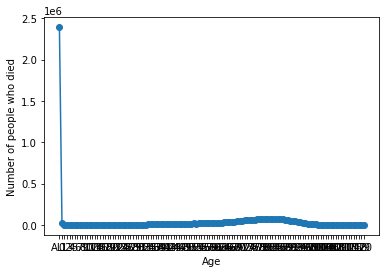

In [5]:
# Load death distribution data
data_url_2 = "https://gist.githubusercontent.com/mbonsma/2f4076aab6820ca1807f4e29f75f18ec/raw/62f3ec07514c7e31f5979beeca86f19991540796/cdc_vs00199_table310.tsv"
death_distribution_data = pd.read_csv(data_url_2, sep='\t')

# Drop NaN values from the 'Both Sexes' column
death_distribution_data = death_distribution_data.dropna(subset=['Both Sexes'])

# Plot the number of people who died as a function of age
fig, ax = plt.subplots()
ax.plot(death_distribution_data['Age'], death_distribution_data['Both Sexes'], marker='o')
ax.set_xlabel("Age")
ax.set_ylabel("Number of people who died")


In [10]:
def P_lh(death_distribution_data, study_year=1990):  
    """ Overall probability of being left-handed if you died in the study year
    Input: dataframe of death distribution data, study year
    Output: P(LH), a single floating point number """
    
    # First, filter out non-numeric age values from death_distribution_data
    death_distribution_data_filtered = death_distribution_data[death_distribution_data['Age'] != 'ALL']

    # Get the ages and compute P(LH | A) for those ages
    ages = death_distribution_data_filtered['Age'].values.astype(int)
    
    # Multiply the number of dead people by P_lh_given_A to get a weighted probability
    p_list = P_lh_given_A(ages, study_year) * death_distribution_data_filtered['Both Sexes'].values  
    
    # Calculate the sum of p_list
    p = np.sum(p_list)  
    
    # Normalize to the total number of people and return
    return p / np.sum(death_distribution_data_filtered['Both Sexes'].values)

print(P_lh(death_distribution_data))

0.08424672059807686


In [11]:
def P_A_given_lh(ages_of_death, death_distribution_data, study_year=1990):
    """ The overall probability of being a particular `age_of_death` given that you're left-handed """
    
    # P(A): Probability of dying at age A
    P_A = death_distribution_data.set_index('Age')['Both Sexes'][ages_of_death].values / np.sum(death_distribution_data['Both Sexes'])
    
    # P(LH): Overall probability of being left-handed
    P_left = P_lh(death_distribution_data, study_year)
    
    # P(LH|A): Probability of being left-handed given that someone died at age A
    P_lh_A = P_lh_given_A(ages_of_death, study_year)
    
    return P_lh_A * P_A / P_left

In [12]:
def P_A_given_rh(ages_of_death, death_distribution_data, study_year=1990):
    """ The overall probability of being a particular `age_of_death` given that you're right-handed """
    
    # P(A): Probability of dying at age A
    P_A = death_distribution_data.set_index('Age')['Both Sexes'][ages_of_death].values / np.sum(death_distribution_data['Both Sexes'])
    
    # P(RH): Overall probability of being right-handed
    P_left = P_lh(death_distribution_data, study_year)
    P_right = 1 - P_left
    
    # P(RH|A): Probability of being right-handed given that someone died at age A
    P_rh_A = 1 - P_lh_given_A(ages_of_death, study_year)
    
    return P_rh_A * P_A / P_right

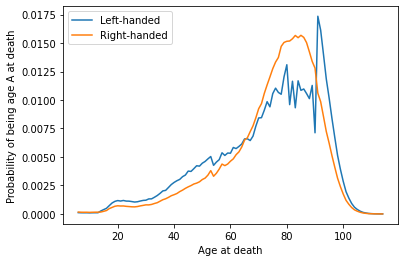

In [13]:
ages = np.arange(6, 115, 1) # make a list of ages of death to plot

# Calculate the probability of being left- or right-handed for each age
left_handed_probability = P_A_given_lh(ages, death_distribution_data)
right_handed_probability = P_A_given_rh(ages, death_distribution_data)

# Create a plot of the two probabilities vs. age
fig, ax = plt.subplots() # create figure and axis objects
ax.plot(ages, left_handed_probability, label="Left-handed")
ax.plot(ages, right_handed_probability, label="Right-handed")
ax.legend() # add a legend
ax.set_xlabel("Age at death")
ax.set_ylabel(r"Probability of being age A at death")
plt.show()

In [14]:
# Calculate average ages for left-handed and right-handed groups
average_lh_age = np.nansum(ages * np.array(left_handed_probability))
average_rh_age = np.nansum(ages * np.array(right_handed_probability))

# Print the average ages for each group
print("Average age of left-handed people at death:", round(average_lh_age, 1))
print("Average age of right-handed people at death:", round(average_rh_age, 1))

# Print the difference between the average ages
print("The difference in average ages is " + str(round(average_rh_age - average_lh_age, 1)) + " years.")

Average age of left-handed people at death: 36.3
Average age of right-handed people at death: 36.7
The difference in average ages is 0.4 years.


In [15]:
# Calculate the probability of being left- or right-handed for all ages in 2018
left_handed_probability_2018 = P_A_given_lh(ages, death_distribution_data, study_year=2018)
right_handed_probability_2018 = P_A_given_rh(ages, death_distribution_data, study_year=2018)

# Calculate average ages for left-handed and right-handed groups in 2018
average_lh_age_2018 = np.nansum(ages * np.array(left_handed_probability_2018))
average_rh_age_2018 = np.nansum(ages * np.array(right_handed_probability_2018))

# Print the difference in average ages for 2018
print("The difference in average ages in 2018 is " + 
      str(round(average_rh_age_2018 - average_lh_age_2018, 1)) + " years.")

The difference in average ages in 2018 is 0.5 years.


#THE END!